# **Análisis y recomendación de perfumes basados en la similitud del coseno**

En este notebook realizaremos un análisis y una posterior recomendación de perfumes con un perfil olfativo similar.\
Para ello, utilizaremos un dataset obtenido de Kaggle, basado en la página web Fragrantica.\
De dicho dataset se han eliminado columnas no relevantes para el análisis, como el enlace a la web o el país de procedencia.

## Importamos las librerías

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tensorflow.keras import layers, models

from collections import Counter
from sklearn.preprocessing import Normalizer




### Cargamos csv

In [2]:
df = pd.read_csv("Libro3.csv", sep=';', encoding='latin1')

### Comenzamos EDA

**Hacemos un análisis de las columnas.**

In [3]:
df.head()

,Perfume,Brand,Gender,Rating Value,Rating Count,Year,Top,Middle,Base,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5
0,accento-overdose-pride-edition,xerjoff,unisex,"1,42",201,2022,"fruity notes, aldehydes, green notes","bulgarian rose, egyptian jasmine, lily-of-the-...","eucalyptus, pine",rose,woody,fruity,aromatic,floral
1,classique-pride-2024,jean-paul-gaultier,women,"1,86",70,2024,"yuzu, citruses","orange blossom, neroli","musk, blonde woods",citrus,white floral,sweet,fresh,musky
2,classique-pride-2023,jean-paul-gaultier,unisex,"1,91",285,2023,"blood orange, yuzu","neroli, orange blossom","musk, white woods",citrus,white floral,sweet,fresh spicy,musky
3,pride-edition-man,bruno-banani,men,"1,92",59,2019,"guarana, grapefruit, red apple","walnut, lavender, guava","vetiver, benzoin, amber",fruity,nutty,woody,tropical,NaN
4,le-male-pride-collector,jean-paul-gaultier,men,"1,93",632,2020,"mint, lavender, cardamom, artemisia, bergamot","caraway, cinnamon, orange blossom","vanilla, sandalwood, amber, cedar, tonka bean",aromatic,warm spicy,fresh spicy,cinnamon,vanilla


Viendo las columnas que tenemos podemos sacar las siguientes conclusiones:

-Perfume: Nombre del perfume.\
-Brand: Marca del perfume.\
-Gender: Género para el que estaba diseñado el perfume.\
-Rating Value: Valoración media del perfume, basada en la valoración dada por todos los usuarios.\
-Year: Año de estreno del perfume.\
-Top: Notas Top (las primeras que se notan al aplicar el perfume).\
-Middle: Notas Middle (las notas que se perciben después de las notas top).\
-Base: Notas Base (Las últimas notas que se perciben).\
-MainaccordX: Acordes principales del perfume. No tienen por qué coincidir necesariamente con las notas Top, Middle o Base.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12705 entries, 0 to 12704
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Perfume       12705 non-null  object
 1   Brand         12705 non-null  object
 2   Gender        12705 non-null  object
 3   Rating Value  12705 non-null  object
 4   Rating Count  12705 non-null  int64 
 5   Year          12705 non-null  int64 
 6   Top           12705 non-null  object
 7   Middle        12705 non-null  object
 8   Base          12705 non-null  object
 9   mainaccord1   12705 non-null  object
 10  mainaccord2   12700 non-null  object
 11  mainaccord3   12644 non-null  object
 12  mainaccord4   12507 non-null  object
 13  mainaccord5   12182 non-null  object
dtypes: int64(2), object(12)
memory usage: 1.4+ MB


Vemos que todas las columnas tiene valores de tipo 'objeto', a continuación comprobaremos los valores nulos.

In [5]:
df.isnull().sum()

Perfume           0
Brand             0
Gender            0
Rating Value      0
Rating Count      0
Year              0
Top               0
Middle            0
Base              0
mainaccord1       0
mainaccord2       5
mainaccord3      61
mainaccord4     198
mainaccord5     523
dtype: int64

Podemos observar valores nulos en las últimas columnas mainaccordX. Esto se debe a que no todos los perfumes presentan el mismo número de acordes principales. A continuación, procederemos a imputar dichos valores nulos.

A la hora de imputar los valores nulos, utilizar estadísticas como la mediana podría generar problemas en el análisis posterior, ya que dicho valor representaría un acorde real y podría distorsionar la información original del perfume.
Por este motivo, se asigna el valor 'none', de forma que, tras la codificación, todos los valores originalmente nulos compartan la misma representación

In [6]:
accordcols = [c for c in df.columns if c.startswith("mainaccord")]
df[accordcols] = df[accordcols].fillna("none")


Codificamos las columnas aplicando la misma condición a todas las columnas, si en la columna 1 el aroma 'x' tiene valor 1, en el resto de columnas también lo será.

In [7]:

ordered = []
for c in accordcols:
    for v in df[c].dropna().astype(str):
        if v not in ordered:
            ordered.append(v)

mapping = {v: i for i, v in enumerate(ordered, start=1)}  
print("Número de categorías encontradas:", len(mapping))
print("Ejemplo de mapping (primeros 10):", dict(list(mapping.items())[:10]))

for c in accordcols:
    df[c] = df[c].map(mapping)


Número de categorías encontradas: 81
Ejemplo de mapping (primeros 10): {'rose': 1, 'citrus': 2, 'fruity': 3, 'aromatic': 4, 'white floral': 5, 'woody': 6, 'powdery': 7, 'leather': 8, 'ozonic': 9, 'vinyl': 10}


Aqui podemos ver los primeros valores de la columna Top.

In [8]:
df['Top'].head()

0             fruity notes, aldehydes, green notes
1                                   yuzu, citruses
2                               blood orange, yuzu
3                   guarana, grapefruit, red apple
4    mint, lavender, cardamom, artemisia, bergamot
Name: Top, dtype: object

Ahora vamos a separar los valores de las columnas Top, Middle y Base, para poder analizarlos por separado y no como un conjunto:

In [9]:

def normalizar_notas(notes):
    if not isinstance(notes, str):
        return []
    return [n.strip().lower() for n in notes.split(',') if n.strip()]


df['Top'] = df['Top'].apply(normalizar_notas)
df['Middle'] = df['Middle'].apply(normalizar_notas)
df['Base'] = df['Base'].apply(normalizar_notas)

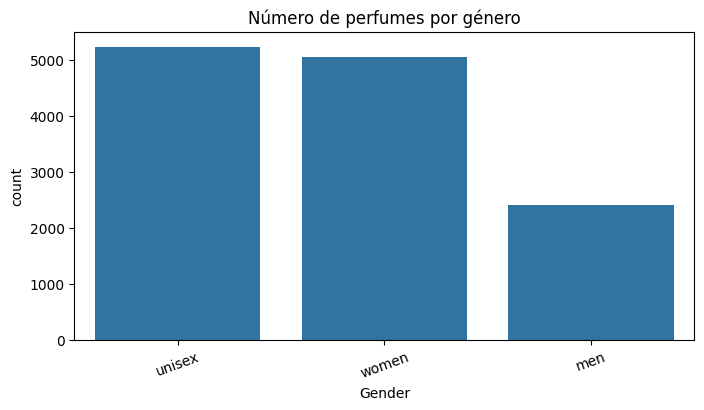

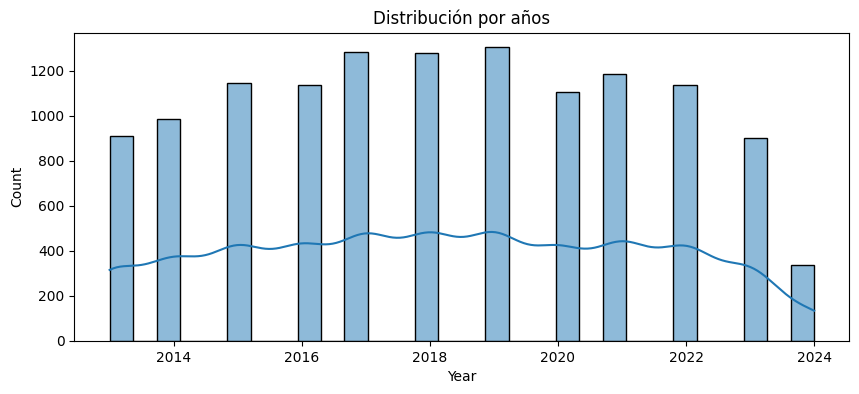

In [10]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="Gender", order=df["Gender"].value_counts().index)
plt.title("Número de perfumes por género")
plt.xticks(rotation=20)
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(df["Year"], bins=30, kde=True)
plt.title("Distribución por años")
plt.show()


En estas gráficas podemos ver la cantidad de perfumes por género y la cantidad de perfumes actualizados por años.

Ahora vamos a coger a partir de las columnas Top, Middle y Base y vamos a extraer sus notas para crear una lista ordenada y sin duplicados de todas las notas que hay en estas columnas.

In [11]:
all_notes = set()

for col in ['Top', 'Middle', 'Base']:
    df[col].apply(lambda x: all_notes.update(x))

all_notes = sorted(all_notes)
print(len(all_notes))

1502


Podemos ver que hay un total de 1502 notas diferentes.\
Ahora vamos a crear el diccionario 'note_to_idx' el cual almacena todas las notas con un identificador único.

In [35]:
note_to_idx = {note: i for i, note in enumerate(all_notes)}
print(list(note_to_idx.items())[:5])

[('absinthe', 0), ('acai berry', 1), ('accord eudora©', 2), ('acerola', 3), ('acerola blossom', 4)]


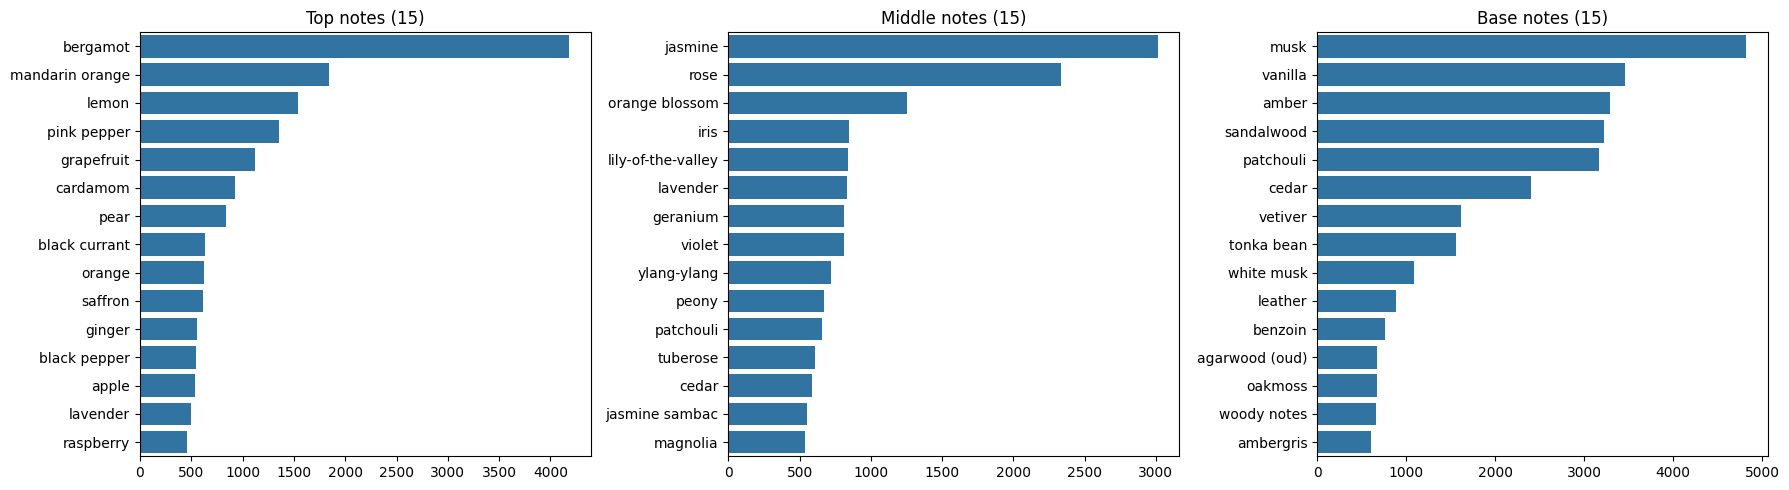

In [13]:

def top_notes_counts(series_of_lists, topn=15):
    c = Counter()
    for lst in series_of_lists.dropna():
        c.update(lst)
    return c.most_common(topn)

# Usar las columnas del dataframe normalizadas
top15_top = top_notes_counts(df['Top'], 15)
top15_mid = top_notes_counts(df['Middle'], 15)
top15_base = top_notes_counts(df['Base'], 15)

fig, axes = plt.subplots(1,3, figsize=(18,5), sharex=False)

for ax, data, title in zip(
    axes,
    [top15_top, top15_mid, top15_base],
    ["Top notes (15)", "Middle notes (15)", "Base notes (15)"]
):
    labels = [x[0] for x in data]
    vals = [x[1] for x in data]
    sns.barplot(x=vals, y=labels, ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.show()


Ahora vamos a aplicarle un peso a cada columna. Este procedimiento se realiza porque, a la hora de valorar un perfume, cada tipo de nota (Top, Middle y Base) tiene una relevancia distinta.\
Los pesos asignados no son valores absolutos, sino una interpretación personal de dicha relevancia, por lo que pueden ajustarse según el criterio del análisis.

In [14]:

WEIGHTS = {
    'top': 0.9,
    'middle': 0.7,
    'base': 0.4
}


El código en la siguiente función se ocupa de aplicar los pesos a todas las notas de las columnas.

In [15]:
def aplicar_pesos(row, note_to_idx, weights):
    vec = np.zeros(len(note_to_idx))

    for n in row['Top']:
        if n in note_to_idx:
            vec[note_to_idx[n]] += weights['top']

    for n in row['Middle']:
        if n in note_to_idx:
            vec[note_to_idx[n]] += weights['middle']
    
    for n in row['Base']:
        if n in note_to_idx:
            vec[note_to_idx[n]] += weights['base']

    return vec


El siguiente código define la variable X_notes, que corresponde a una matriz de tamaño 12705 × 1502, donde cada fila representa el vector ponderado de notas asociado a un perfume.

In [16]:
X_notes = np.vstack(df.apply(lambda row: aplicar_pesos(row, note_to_idx, WEIGHTS), axis=1))

print(X_notes.shape)

(12705, 1502)


Con el siguiente código podemos ver los valores del vector de la posición 1.

In [17]:
s = pd.Series(X_notes[1], index=all_notes)
notes= s[s != 0].sort_values(ascending=False).head(20)
print(notes)

citruses          0.9
yuzu              0.9
orange blossom    0.7
neroli            0.7
blonde woods      0.4
musk              0.4
dtype: float64


Ahora vamos a comenzar con las columnas de mainaccordsX:

In [18]:
accord_cols = [
    'mainaccord1',
    'mainaccord2',
    'mainaccord3',
    'mainaccord4',
    'mainaccord5'
]


Comenzamos normalizando todos los valores de las las columnas:

In [19]:
def normalizar_main(a):
    if pd.isna(a):
        return None
    return str(a).strip().lower()


In [20]:
for col in accord_cols:
    df[col] = df[col].apply(normalizar_main)


Definimos una lista de 'mainaccords' únicos, aqui vemos que hay muchos menos accordes diferentes ya que solo hay 81.

In [21]:
accord_vocab = set()

for col in accord_cols:
    accord_vocab.update(df[col].dropna().unique())

accord_vocab = sorted(accord_vocab)
len(accord_vocab), accord_vocab[:10]


(81, ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18'])

In [22]:
accord_to_idx = {a: i for i, a in enumerate(accord_vocab)}

Volvemos a aplicarle un valor de pesos a cada columna para aplicarle relevancia.

In [23]:
MAIN_WEIGHTS = {
    1: 1.0,
    2: 0.8,
    3: 0.8,
    4: 0.7,
    5: 0.5
}


Realizamos los mismos pasos que antes, creamos la matriz con los pesos ya aplicados.

In [24]:
def aplicar_pesos_main(row, accord_to_idx, weights):
    vec = np.zeros(len(accord_to_idx))

    for i, col in enumerate(accord_cols, start=1):
        accord = row[col]
        if accord in accord_to_idx:
            vec[accord_to_idx[accord]] += weights[i ]

    return vec

In [25]:
X_accords = np.vstack(
    df.apply(
        lambda row: aplicar_pesos_main(row, accord_to_idx, MAIN_WEIGHTS),
        axis=1
    )
)

X_accords.shape


(12705, 81)

Una vez construidas ambas matrices, verificamos sus dimensiones. Podemos observar que ambas contienen el mismo número de filas (un perfume por fila), mientras que difieren en el número de columnas.

In [26]:
print(X_notes.shape, X_accords.shape)


(12705, 1502) (12705, 81)


Creamos una matriz total con las dos submatrices concatenadas.

In [27]:
X_total = np.hstack([X_notes, X_accords])
print(X_total.shape)

(12705, 1583)


Paso final: Definir los perfumes más similares del perfume definido por parámetro:

In [28]:
normalizer = Normalizer(norm='l2')#Aplicamos la noralización L2 a la matriz X_total
X = normalizer.fit_transform(X_total)

#Creamos un diccionario para guardar los nombres de cada perfume y su índice
name_to_idx = pd.Series(df.index.values, index=df["Perfume"].astype(str)).to_dict()

def topn_similarities(perfume_name, topn= 10, filtrar_genero = None, misma_marca = None):
    if perfume_name not in name_to_idx:
        raise ValueError(f"Perfume '{perfume_name}' no encontrado en el dataset.")
    
    i = name_to_idx[perfume_name]#Buscamos el índice del perfume en el diccionario
    q = X[i].reshape(1, -1)#Hacemos el vector de consulta

    sims = cosine_similarity(q, X).ravel()#Calculamos las similitudes coseno entre el vector de consulta y todos los vectores
    #sims[i] = -1.0  # Excluimos el mismo perfume

    mask = np.ones(len(df), dtype=bool)#Máscara para poder filtrar por los géneros definidos

    if filtrar_genero is not None:
        # ejemplo: filtrar_genero = ["men", "unisex"]
        mask &= df["Gender"].isin(filtrar_genero).values
    
    
    if misma_marca is True:
        mask &= (df["Brand"].values == df.loc[i, "Brand"])#Busca solo perfumes de la misma marca
    elif isinstance(misma_marca, str):
        mask &= (df["Brand"].values == misma_marca)

    # aplica máscara para obtener los indices validos y sus similitudes
    valid_idx = np.where(mask)[0]
    valid_sims = sims[valid_idx]

    # topn sin ordenar todo
    k = min(topn, len(valid_idx))
    top_local = np.argpartition(-valid_sims, kth=k-1)[:k]
    top_idx = valid_idx[top_local]

    # orden final por score
    top_idx = top_idx[np.argsort(-sims[top_idx])]

    out = df.loc[top_idx, ["Perfume", "Brand", "Gender", "Year"]].copy()
    out["sim"] = sims[top_idx]
    return out.reset_index(drop=True)

Una vez hemos hecho la función la probamos con el perfume "le male pride collector":

In [29]:
topn_similarities("le-male-pride-collector", topn=10, filtrar_genero=["men","unisex"])


,Perfume,Brand,Gender,Year,sim
0,le-male-pride-collector,jean-paul-gaultier,men,2020,1.000000
1,le-male-eau-de-toilette-airlines,jean-paul-gaultier,men,2020,0.958244
2,le-male-pirate-edition,jean-paul-gaultier,men,2015,0.958244
3,le-male-collector-edition-2017,jean-paul-gaultier,men,2017,0.937901
4,infinite-navy,caline,men,2022,0.910458
5,le-male-collector-s-snow-globe,jean-paul-gaultier,men,2019,0.895075
6,max,paris-elysees,men,2015,0.890962
7,le-male-couple,jean-paul-gaultier,men,2013,0.886510
8,le-male-x-mas-edition-2020,jean-paul-gaultier,men,2020,0.885439
9,le-male-collector-edition-2018,jean-paul-gaultier,men,2018,0.806210


Podemos ver que nos recomienda sobretodo perfumes de la mísma linea, aunque no hayamos especificado que los queríamos de la misma marca, esto tiene sentido ya que todos los perfumes de la misma línea de perfumes comparten 'ADN' y sufren pequeños cambios, por lo que tiene sentido que sean similares.

Ahora vamos a pedir los similares del mismo perfume pero añadiendo a la tabla los datos del dataset de cada perfume, para poder ver cuantas notas coinciden entre estos:

In [30]:
rec = topn_similarities("le-male-pride-collector", topn=4)
df[df["Perfume"].eq("le-male-pride-collector")][["Perfume","Brand","Top","Middle","Base","mainaccord1","mainaccord2","mainaccord3","mainaccord4","mainaccord5"]]
rec.merge(df[["Perfume","Brand","mainaccord1","mainaccord2","mainaccord3","mainaccord4","mainaccord5"]],
          on=["Perfume","Brand"], how="left")


,Perfume,Brand,Gender,Year,sim,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5
0,le-male-pride-collector,jean-paul-gaultier,men,2020,1.000000,4,13,26,58,17
1,le-male-pirate-edition,jean-paul-gaultier,men,2015,0.958244,4,13,26,17,16
2,le-male-eau-de-toilette-airlines,jean-paul-gaultier,men,2020,0.958244,4,13,26,17,6
3,le-male-collector-edition-2017,jean-paul-gaultier,men,2017,0.937901,4,17,26,20,13


Podemos ver que los acordes principañles coinciden diferenciandose muy pocos unos de otros, lo que significa que hemos cumplido el objetivo de recomendar perfumes similares.

Para terminar de verificarlo vamos a representar en una gráfica las notas Top, Middle y Base de el perfume dado como parámetro y el que segun el la similitud del coseno debería ser el mas similar:

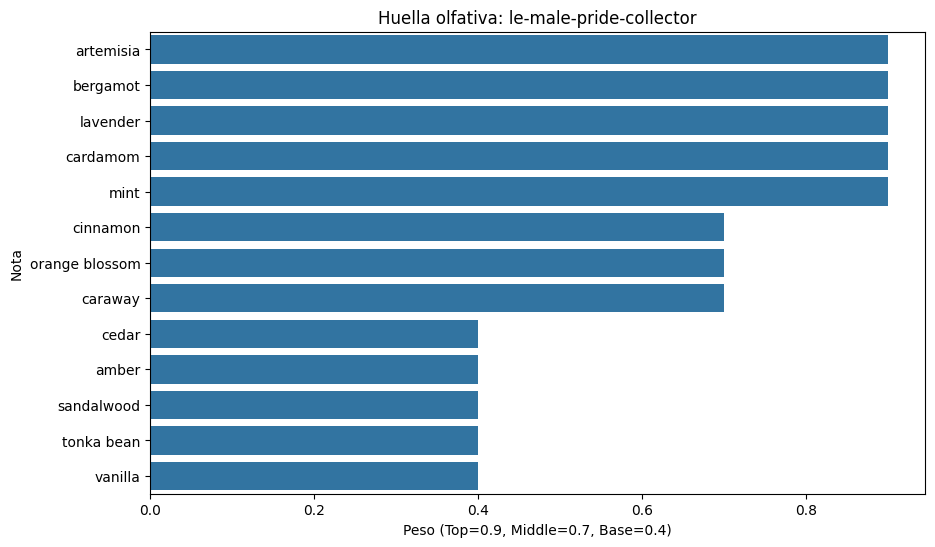

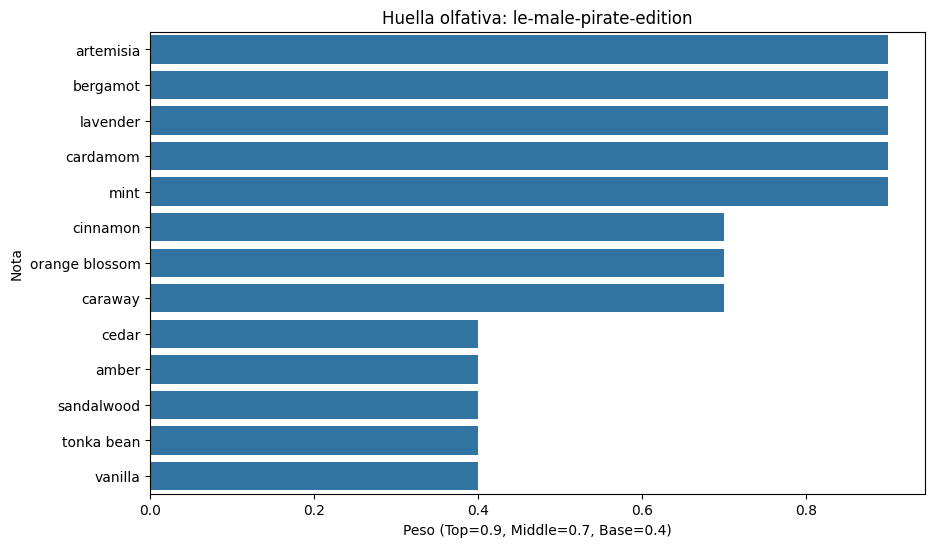

In [31]:
def perfume_notas(perfume_name, df, name_to_idx=name_to_idx, note_to_idx=note_to_idx, X_notes=X_notes, max_items=25):
    if perfume_name not in name_to_idx:
        raise ValueError(f"Perfume '{perfume_name}' no encontrado en el dataset.")
    i = name_to_idx[perfume_name]
    v = X_notes[i]
    # quedarnos con posiciones no-cero
    nz = np.where(v > 0)[0]
    # ordenar por peso desc y limitar
    nz = nz[np.argsort(-v[nz])][:max_items]

    idx_to_note = {idx: note for note, idx in note_to_idx.items()}
    notes = [idx_to_note.get(j, f"idx_{j}") for j in nz]
    weights = v[nz]

    plt.figure(figsize=(10,6))
    sns.barplot(x=weights, y=notes)
    plt.title(f"Huella olfativa: {perfume_name}")
    plt.xlabel("Peso (Top=0.9, Middle=0.7, Base=0.4)")
    plt.ylabel("Nota")
    plt.show()

# :
perfume_notas("le-male-pride-collector", df)
perfume_notas("le-male-pirate-edition", df)



Analizando las gráficas, podemos observar que los valores de estas tres columnas son idénticos para ambos perfumes, lo que indica que, según el dataset, comparten las mismas notas.\
Las únicas diferencias aparecen en los acordes mainaccord4 y mainaccord5, donde uno de ellos mantiene el mismo acorde pero en distinto orden (lo que afecta al peso durante la vectorización), y el otro difiere entre ambos perfumes.

In [32]:
for f in mapping.items():
    if f[1] == 16 or f[1] == 58:
        print(f)

('green', 16)
('cinnamon', 58)


![alt text](image.png)

Podemos observar que los acordes principales coinciden en gran medida, presentando únicamente diferencias menores. Esto indica que el objetivo de recomendar perfumes con perfiles olfativos similares se ha cumplido correctamente.